In [1]:
import os
import torch
import sys
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.manifold import TSNE
import pylab as py

import warnings
warnings.filterwarnings('ignore')

from fastprogress import master_bar, progress_bar

In [2]:
if not os.path.exists('./saved_models'):
    os.mkdir('./saved_models')
    
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [3]:
num_epochs = 100
batch_size = 512
learning_rate = 1e-3

In [4]:
train_dataset = MNIST('../data', train=True, transform=img_transform)
test_dataset = MNIST('../data', train=False, transform=img_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=8)

In [5]:
device = 'cuda:4' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:4


In [6]:
class DAM(nn.Module):
    """ Discriminative Amplitude Modulator Layer (1-D) """
    def __init__(self, in_dim):
        super(DAM, self).__init__()
        self.in_dim = in_dim
        
        self.mu = torch.arange(0, self.in_dim).float()/self.in_dim * 5
        self.mu = nn.Parameter(self.mu, requires_grad=False)
        self.beta = nn.Parameter(torch.ones(1), requires_grad=True)
        self.alpha = nn.Parameter(torch.ones(1), requires_grad=False)
        self.register_parameter('mu', self.mu)
        self.register_parameter('beta', self.beta)
        self.register_parameter('alpha', self.alpha)
        
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        
    def forward(self, x):
        return x * self.mask()
    
    def mask(self):
        return self.relu(self.tanh((self.alpha ** 2) * (self.mu + self.beta)))

In [7]:
class AEnc(nn.Module):
    def __init__(self, init_dim):
        super(AEnc, self).__init__()
        self.enc_layer_1 = nn.Linear(28 * 28, 128)
        self.enc_layer_2 = nn.Linear(128, 64)
        self.enc_layer_3 = nn.Linear(64, 32)
        self.enc_layer_4 = nn.Linear(32, init_dim)
        self.dam_layer = DAM(init_dim)
        self.dec_layer_1 = nn.Linear(init_dim, 32)
        self.dec_layer_2 = nn.Linear(32, 64)
        self.dec_layer_3 = nn.Linear(64, 128)
        self.dec_layer_4 = nn.Linear(128, 28 * 28)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        
        
    def forward(self, x):
        out = self.relu(self.enc_layer_1(x))
        out = self.relu(self.enc_layer_2(out))
        out = self.relu(self.enc_layer_3(out))
        h = self.enc_layer_4(out)
        h = self.dam_layer(h)
        x_r = self.relu(self.dec_layer_1(h))
        x_r = self.relu(self.dec_layer_2(x_r))
        x_r = self.relu(self.dec_layer_3(x_r))
        x_r = self.tanh(self.dec_layer_4(x_r))
        return x_r, h

In [8]:
class SLM(nn.Module):
    """ Network Sliming Modulator Layer (1-D) """
    def __init__(self, in_dim):
        super(SLM, self).__init__()
        self.in_dim = in_dim
        self.mu = nn.Parameter(torch.ones(self.in_dim).float(), requires_grad=True)
        self.register_parameter('mu', self.mu)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        
    def forward(self, x):
        return x * self.mask()
    
    def mask(self):
        return self.relu(self.mu)

In [9]:
class AEncS(nn.Module):
    def __init__(self, init_dim):
        super(AEncS, self).__init__()
        self.enc_layer_1 = nn.Linear(28 * 28, 128)
        self.enc_layer_2 = nn.Linear(128, 64)
        self.enc_layer_3 = nn.Linear(64, 32)
        self.enc_layer_4 = nn.Linear(32, init_dim)
        self.dam_layer = SLM(init_dim)
        self.dec_layer_1 = nn.Linear(init_dim, 32)
        self.dec_layer_2 = nn.Linear(32, 64)
        self.dec_layer_3 = nn.Linear(64, 128)
        self.dec_layer_4 = nn.Linear(128, 28 * 28)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        
        
    def forward(self, x):
        out = self.relu(self.enc_layer_1(x))
        out = self.relu(self.enc_layer_2(out))
        out = self.relu(self.enc_layer_3(out))
        h = self.enc_layer_4(out)
        h = self.dam_layer(h)
        x_r = self.relu(self.dec_layer_1(h))
        x_r = self.relu(self.dec_layer_2(x_r))
        x_r = self.relu(self.dec_layer_3(x_r))
        x_r = self.tanh(self.dec_layer_4(x_r))
        return x_r, h

In [10]:
# from plot_settings import global_settings
# global_settings()

import matplotlib as mpl
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

In [34]:
init_dims = [50] #100
lambda_rs = [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 8.0, 11.0]
dam_btl_dim_mean = []
dam_btl_dim_std = []
dam_rec_loss_mean = []
dam_rec_loss_std = []

dam_btl_dims = []
dam_rec_losses = []

criterion = nn.MSELoss()

for init_dim in init_dims:
    init_dim_btl_mean = []
    init_dim_btl_std = []
    init_dim_rec_mean = []
    init_dim_rec_std = []
    for lambda_r in lambda_rs:
        btl_neurons = []
        rec_loss = []
        model_name = str(init_dim)+'x'+str(lambda_r)
        for run in range(1,6):
            net = AEnc(init_dim).to(device)
            if not os.path.exists('saved_models/dam_model_'+model_name+'_run_'+str(run)+'.pt'):
                continue
            
            net.load_state_dict(torch.load('saved_models/dam_model_'+model_name+'_run_'+str(run)+'.pt'))
            print('.', end='')
            btl_d = (net.dam_layer.mask().detach().cpu().numpy() > 0).sum()
            btl_neurons.append(btl_d)
            
            net.eval()
            # call for downstream classification function
            test_mse = 0
            count = 0
            for data in test_loader:
                img, _ = data
                img = img.view(img.size(0), -1)
                img = img.to(device)
                output, _ = net(img)
                test_mse += criterion(output, img)
                count += 1
            rec_loss.append((test_mse/count).item())
        
        dam_btl_dims += btl_neurons
        dam_rec_losses += rec_loss 
        init_dim_btl_mean.append(np.mean(btl_neurons))
        init_dim_btl_std.append(np.std(btl_neurons))
        init_dim_rec_mean.append(np.mean(rec_loss))
        init_dim_rec_std.append(np.std(rec_loss))
        
        print()
        
    dam_btl_dim_mean.append(init_dim_btl_mean)
    dam_btl_dim_std.append(init_dim_btl_std)
    dam_rec_loss_mean.append(init_dim_rec_mean)
    dam_rec_loss_std.append(init_dim_rec_std)
            

.....
.....
.....
.....
.....
.....
.....
.....



In [35]:
slm_btl_dim_mean = []
slm_btl_dim_std = []
slm_rec_loss_mean = []
slm_rec_loss_std = []

slm_btl_dims = []
slm_rec_losses = []

criterion = nn.MSELoss()

for init_dim in init_dims:
    init_dim_btl_mean = []
    init_dim_btl_std = []
    init_dim_rec_mean = []
    init_dim_rec_std = []
    for lambda_r in lambda_rs:
        btl_neurons = []
        rec_loss = []
        model_name = str(init_dim)+'x'+str(lambda_r)
        for run in range(1, 6):
            net = AEncS(init_dim).to(device)
            net.load_state_dict(torch.load('saved_models/slm_model_'+model_name+'_run_'+str(run)+'.pt'))
            print('.', end='')
            
            btl_d = (net.dam_layer.mask().detach().cpu().numpy() > 0).sum()
            btl_neurons.append(btl_d)
            
            net.eval()
            test_mse = 0
            count = 0
            for data in test_loader:
                img, _ = data
                img = img.view(img.size(0), -1)
                img = img.to(device)
                output, _ = net(img)
                test_mse += criterion(output, img)
                count += 1
            rec_loss.append((test_mse/count).item())
            
        slm_btl_dims += btl_neurons
        slm_rec_losses += rec_loss 
        init_dim_btl_mean.append(np.mean(btl_neurons))
        init_dim_btl_std.append(np.std(btl_neurons))
        init_dim_rec_mean.append(np.mean(rec_loss))
        init_dim_rec_std.append(np.std(rec_loss))
        
        print()
        
    slm_btl_dim_mean.append(init_dim_btl_mean)
    slm_btl_dim_std.append(init_dim_btl_std)
    slm_rec_loss_mean.append(init_dim_rec_mean)
    slm_rec_loss_std.append(init_dim_rec_std)

.....
.....
.....
.....
.....
.....
.....
.....
.....


In [40]:
import matplotlib as mpl
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

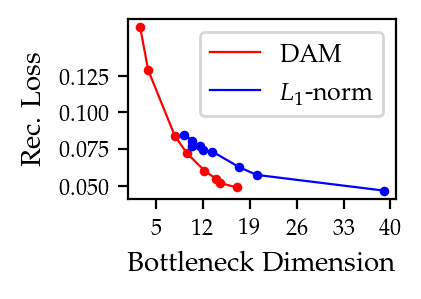

In [41]:
fig, ax = plt.subplots(figsize=(2.2, 1.60), dpi=200)

plt.scatter( dam_btl_dim_mean[0], dam_rec_loss_mean[0],marker='o', s=6, color='r')
plt.plot( dam_btl_dim_mean[0], dam_rec_loss_mean[0], color='r', label='DAM', lw=0.8)
plt.scatter(slm_btl_dim_mean[0], slm_rec_loss_mean[0], marker='o', s=6, color='b')
plt.plot(slm_btl_dim_mean[0], slm_rec_loss_mean[0], color='b', label='$L_{1}$-norm', lw=0.8)

py.legend(loc='upper right', fontsize=9)
plt.xlabel('Bottleneck Dimension')
plt.ylabel('Rec. Loss')
plt.xticks(np.arange(5, max(slm_btl_dim_mean[0])+2, 7), fontsize=8)
plt.yticks(np.linspace(start=0.050, stop=0.125, num=4), fontsize=8)
fig.tight_layout()
fig.savefig("plots/mnist_rec_loss.pdf", dpi=400, transparent=True, bbox_inches='tight')
plt.show()

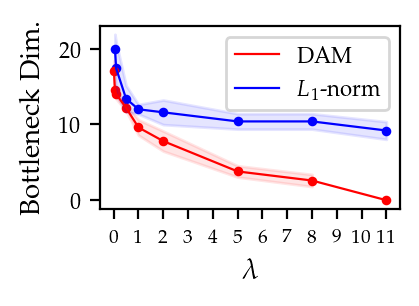

In [47]:
fig, ax = plt.subplots(figsize=(2.2, 1.60), dpi=200)
lambdas_ = [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 8.0, 11.0]
btls_ = dam_btl_dim_mean[0]
for indx, x in enumerate(btls_):
    if x!=x:
        btls_[indx] = 0
        
btls_slm = slm_btl_dim_mean[0]
stds_ = dam_btl_dim_std[0]
stds_slm = slm_btl_dim_std[0]

# print(lambdas_)
# print(btls_slm)
# print(slm_btl_dim_mean[0])


plt.scatter( lambdas_, btls_, marker='o', s=6, color='r')
plt.plot( lambdas_, btls_, color='r', label='DAM', lw=0.8)
plt.scatter( lambdas_[1:], btls_slm[1:], marker='o', s=6, color='b', zorder=-1)
plt.plot( lambdas_[1:], btls_slm[1:], color='b', label='$L_{1}$-norm', lw=0.8)
plt.fill_between(lambdas_, np.array(btls_)-np.array(stds_), np.array(btls_)+np.array(stds_), color='r', alpha=0.1)
plt.fill_between(lambdas_[1:], np.array(btls_slm[1:])-np.array(stds_slm[1:]), np.array(btls_slm[1:])+np.array(stds_slm[1:]), color='b', alpha=0.1)

py.legend(loc='upper right', fontsize=8)
plt.xticks(np.arange(0, max(lambdas_)+1, 1), fontsize=7)
plt.yticks(np.arange(0, 30, 10), fontsize=8)
plt.xlabel(r'$\lambda$')
plt.ylabel('Bottleneck Dim.')
fig.tight_layout()
fig.savefig("plots/mnist_lambda_btl.pdf", dpi=400, transparent=True, bbox_inches='tight')
plt.show()